> (Última Actualización: 11 de Noviembre de 2025)

# **Introducción al modelado continuo** (*a.k.a.* **Ecuaciones de la física matemática**)
## Laboratorio numérico

Bienvenidos al laboratorio numérico de la materia *Introducción al modelado continuo*, también conocida como *Ecuaciones de la física matemática*. En este, vamos a ver métodos numéricos para resolver distintos tipos de problemas de manera general, y su relación y aplicación a problemas específicos de la materia, de manera tal de complementar los contenidos de la cursada teórico-práctica.

# Motivación de este colab

Anteriormente, vimos el **método de diferencias finitas (FD)**. Este método aproxima las derivadas utilizando información *local* de la función en puntos cercanos de una grilla. Es conceptualmente sencillo y versátil, pero su precisión suele estar limitada por el tamaño del paso de la grilla ($h$), con errores que típicamente escalan como potencias de $h$ (e.g., $O(h^2)$ para diferencias centrales).

En esta práctica, exploraremos una familia diferente de métodos: los **métodos espectrales**. A diferencia de FD, los métodos espectrales utilizan información *global* de la función sobre todo el dominio para aproximar las derivadas. Representan la función como una suma de funciones base (como senos y cosenos, o polinomios especiales) que están definidas en todo el dominio.

La principal ventaja de los métodos espectrales es su **alta precisión** (conocida como *convergencia espectral*) para funciones suaves. Mientras que para duplicar la precisión en FD podríamos necesitar reducir $h$ a la mitad (y por lo tanto cuadruplicar el trabajo en 2D), en métodos espectrales, aumentar ligeramente el número de funciones base puede disminuir el error en *varios órdenes de magnitud*.

Sin embargo, esta alta precisión usualmente requiere que la solución sea suficientemente suave (muchas derivadas continuas). Además, la implementación, especialmente para geometrías complejas o condiciones de contorno no periódicas, puede ser más intrincada que con FD.

En este Colab, nos enfocaremos en la idea fundamental detrás de los métodos espectrales, particularmente el **método espectral de Fourier**, ideal para problemas con condiciones de contorno periódicas. Definiremos cómo calcular derivadas usando transformadas de Fourier y resolveremos problemas sencillos para ilustrar su potencia y características, sin adentrarnos aún en las PDEs paradigmáticas de la física matemática.

In [1]:
import numpy as np
np.set_printoptions(legacy='1.25')
import matplotlib.pyplot as plt
import scipy as sp

# Retina for matplotlib
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

---
# Ecuaciones diferenciales

Una ecuación diferencial es una ecuación que implica variables, funciones de variables, y combinaciones de sus derivadas. De manera general, se pueden describir de la siguiente forma:

$$
\mathcal{D}[u(x)] = g(x), \quad x \in [a, b],
$$

donde $\mathcal{D}$ es un operador diferencial que aplica una combinación de derivadas (por ejemplo, $\mathcal{D}[u] = u'$ o $\mathcal{D}[u] = u''$) y $g(x)$ es un término fuente o función conocida. Este problema se resuelve sujeto a condiciones de contorno en los extremos $x_1 = a$ y $x_N = b$, es decir a imposiciones sobre los valores de $u$ o sus derivadas, como por ejemplo $u(x_1) = \alpha$ o $u'(x_N) = \delta$.

Por lo tanto, resulta relevante explorar métodos numéricos para aproximar derivadas, como vimos previamente con el método de diferencias finitas, de manera tal de poder resolver la ecuación diferencial asociada a un problema. De la misma manera, los **métodos espectrales** pueden interpretarse como métodos globales que aproximan derivadas, donde la solución se expresa como una combinación de funciones base cuyas derivadas son conocidas analíticamente.

---
# Métodos espectrales

La idea central es aproximar una función $u(x)$ en un dominio (por ahora, $[0, L]$) mediante una serie truncada de funciones base $\phi_k(x)$ que son *globales* (definidas en todo el dominio) y *ortogonales* (o casi):

$$
u(x) \approx u_N(x) = \sum_{k=0}^{N-1} \hat{u}_k \phi_k(x)
$$

Donde $\hat{u}_k$ son los coeficientes espectrales (o de la serie) que determinan cuánto "pesa" cada función base en la aproximación.

Una vez que tenemos esta representación, las derivadas se calculan derivando la serie término a término:

$$
\frac{d^n u}{dx^n} \approx \frac{d^n u_N}{dx^n} = \sum_{k=0}^{N-1} \hat{u}_k \frac{d^n \phi_k(x)}{dx^n}
$$

La elección de las funciones base $\phi_k(x)$ es crucial y depende de las **condiciones de contorno** del problema.

Para **condiciones periódicas**, se usan series de Fourier (senos y cosenos o exponenciales complejas $e^{ikx}$). Para **condiciones de contorno de Dirichlet o Neumann** en dominios finitos, se usan polinomios ortogonales, como los polinomios de Chebyshev o Legendre.

En esta guía, nos centraremos en el **método espectral de Fourier** por su simplicidad conceptual y conexión directa con la Transformada de Fourier Discreta (DFT).

---
# Método espectral de Fourier (condiciones periódicas)

Supongamos que tenemos una función $u(x)$ definida en un dominio periódico $x \in [0, 2\pi]$ (podemos reescalar cualquier dominio $[0, L]$ a $[0, 2\pi]$). La representamos mediante una serie de Fourier:

$$
u(x) = \sum_{k=-\infty}^{\infty} \hat{u}_k e^{ikx}
$$

Donde $k$ es el número de onda y $\hat{u}_k$ son los coeficientes de Fourier complejos.

La $n$-ésima derivada de $u(x)$ es entonces:

$$
\frac{d^n u(x)}{dx^n} = \sum_{k=-\infty}^{\infty} (ik)^n \hat{u}_k e^{ikx}
$$

La derivación en el espacio real se convierte en una **multiplicación** por $(ik)^n$ en el espacio de Fourier (o espacio espectral).

En la práctica, trabajamos con la función $u(x)$ evaluada en $N$ puntos equiespaciados en el dominio $x_j = j \frac{2\pi}{N}$ para $j = 0, 1, \dots, N-1$. Denotamos $u_j = u(x_j)$. Usamos entonces la **Transformada Discreta de Fourier (DFT)**, que relaciona los valores $u_j$ con los coeficientes de Fourier discretos $\hat{u}_k$:

$$
\hat{u}_k = \frac{1}{N} \sum_{j=0}^{N-1} u_j e^{-ikx_j}
$$

Para recuperar los valores $u_j$ a partir de los coeficientes $\hat{u}_k$ podemos usar la transformada inversa (IDFT).

La DFT y la IDFT se pueden calcular eficientemente usando el algoritmo de la **Transformada Rápida de Fourier (FFT)**, implementado en librerías como `numpy.fft` o `scipy.fft`.

---
## Cálculo de derivadas usando FFT

El procedimiento para calcular la $n$-ésima derivada $u^{(n)}(x)$ en los puntos $x_j$ usando FFT es:

1.  **Transformar:** Calcular los coeficientes $\hat{u}_k$ a partir de los valores $u_j$ usando la FFT: $\hat{\mathbf{u}} = \text{FFT}(\mathbf{u})$.
2.  **Multiplicar:** Multiplicar cada coeficiente $\hat{u}_k$ por $(ik)^n$, donde $k$ son los números de onda correspondientes a cada coeficiente. Necesitamos el vector de números de onda $k$. Para `scipy.fft`, la función `2 * np.pi * fftfreq(N, d=dx)` nos da los números de onda $k$ en el orden correcto. (El factor $2\pi$ es por la convención $e^{ikx}$). *¡Cuidado con $k=0$ si $n \ge 1$!* El coeficiente $\hat{u}_0$ corresponde al valor medio de la función; su derivada es cero.
3.  **Anti-tansformar:** Aplicar la FFT inversa (IFFT) al vector de coeficientes modificados: $\mathbf{u}^{(n)} = \text{IFFT}((ik)^n \hat{\mathbf{u}})$. El resultado será (en general) complejo, pero si la función original es real, la parte imaginaria debería ser numéricamente cero (o muy pequeña).

Este proceso nos da los valores de la $n$-ésima derivada en los puntos $x_j$.

**Ejemplo**

Sea $u(x) = \frac{1}{\sqrt{2\pi}}e^{-(x-\pi)^2}$, calculemos su derivada usando la FFT

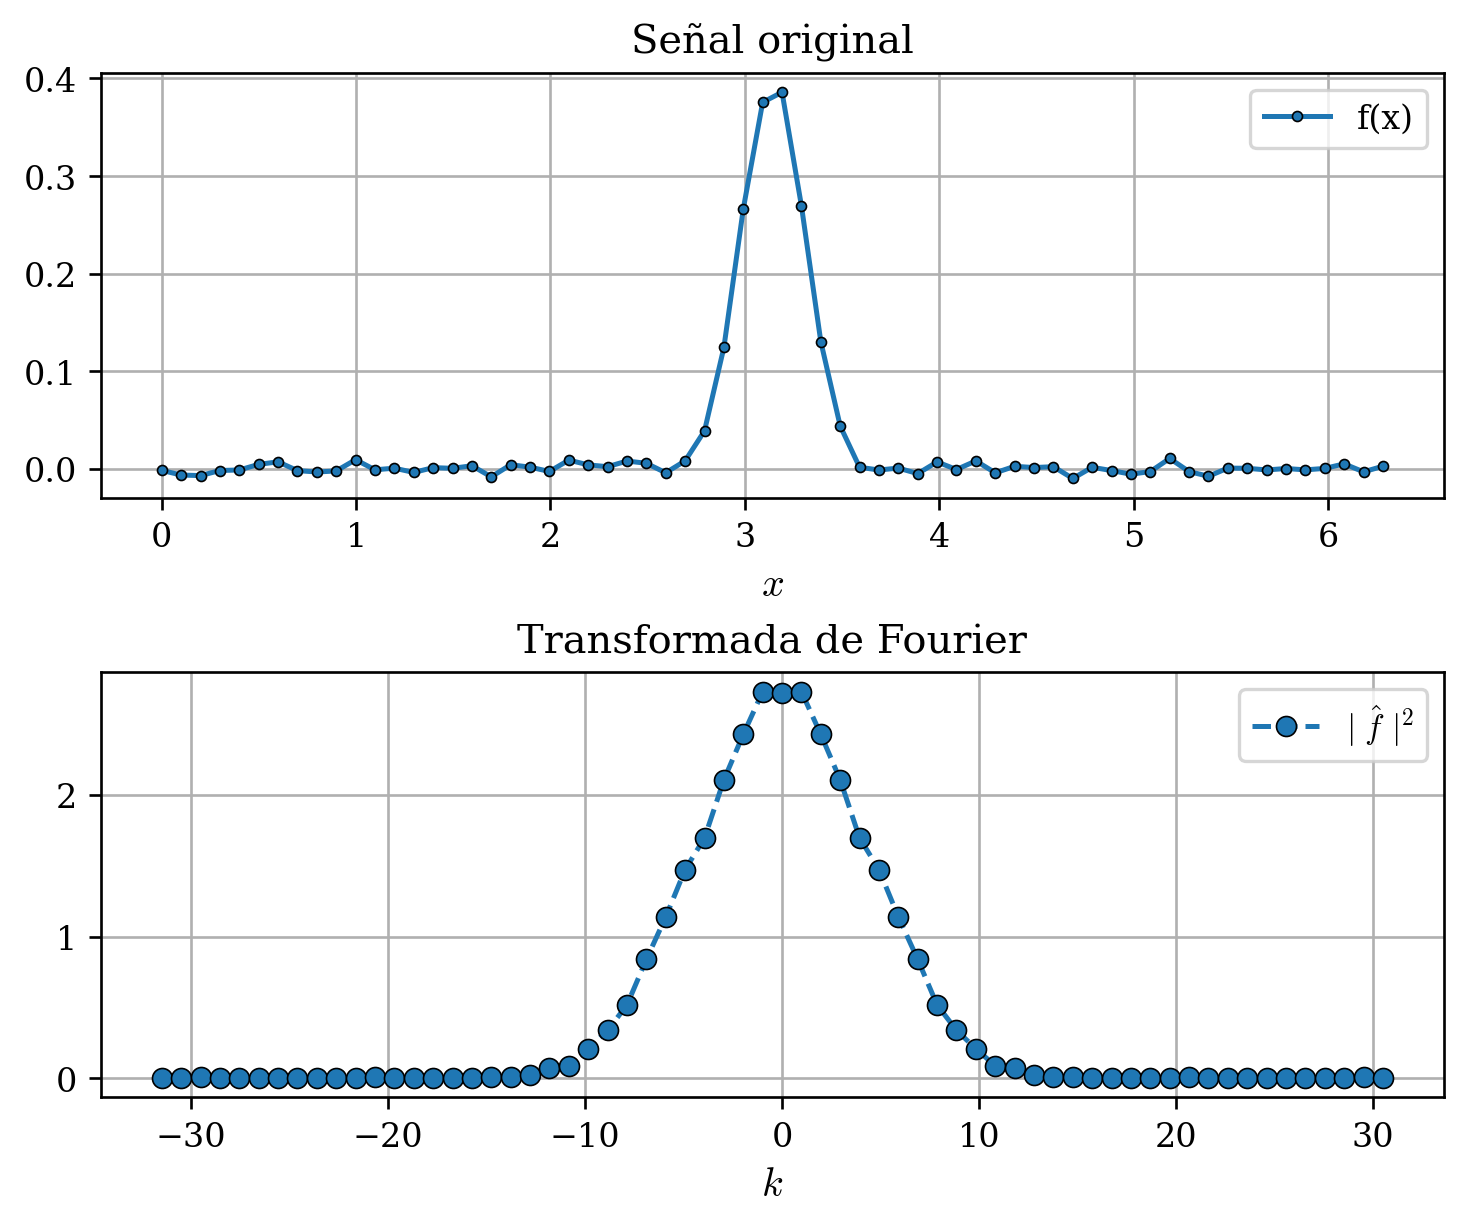

In [13]:
x = np.linspace(0, 2*np.pi, 64)
dx = x[1] - x[0]
# Por ejemplo, una señal gaussiana centrada en pi
f = np.exp(-((x - np.pi)*3*np.sqrt(2))**2 ) / np.sqrt(2*np.pi) + 0.005*np.random.randn(len(x))  # Prueben agregar ruido y vean el efecto en la derivada

fig, axs = plt.subplots(2, 1, figsize=(6, 5), constrained_layout=True)
axs[0].plot(x, f, ".-", mec="k", mew=0.5, label="f(x)")
axs[0].grid()
axs[0].legend()
axs[0].set_title("Señal original")
axs[0].set_xlabel("$x$")
# axs[0].set_ylabel("$f(x)$")

# Transformada de Fourier
f_hat = np.fft.fft(f)
# (esta es una forma un poco más general de conseguir las frecuencias que lo que vimos hace unas clases)
k = 2 * np.pi * np.fft.fftfreq(len(f), d=dx)  # Números de onda asociados.
k = np.fft.fftshift(k)  # Reordenar frecuencias para que vayan de -k_max a k_max
f_hat = np.fft.fftshift(f_hat)  # Reordenar la transformada para que coincida con las frecuencias

# Alternativamente:
# F = sp.fft.rfft(f)
# freq = sp.fft.rfftfreq(len(f), d=dx)

axs[1].plot(k, np.abs(f_hat)**2, "o--", mec="k", mew=0.5, label=r"$|\ \hat{f}\ |^2$")
# axs[1].plot(k, np.real(f_hat), "o--", mec="k", mew=0.5, label=r"$\Re \hat{f}$")
# axs[1].plot(k, np.imag(f_hat), "o--", mec="k", mew=0.5, label=r"$\Im \hat{f}$")
axs[1].grid()
axs[1].legend()
axs[1].set_title("Transformada de Fourier")
axs[1].set_xlabel("$k$")
# axs[1].set_ylabel(r"$\hat{f}(k)$")

plt.show()

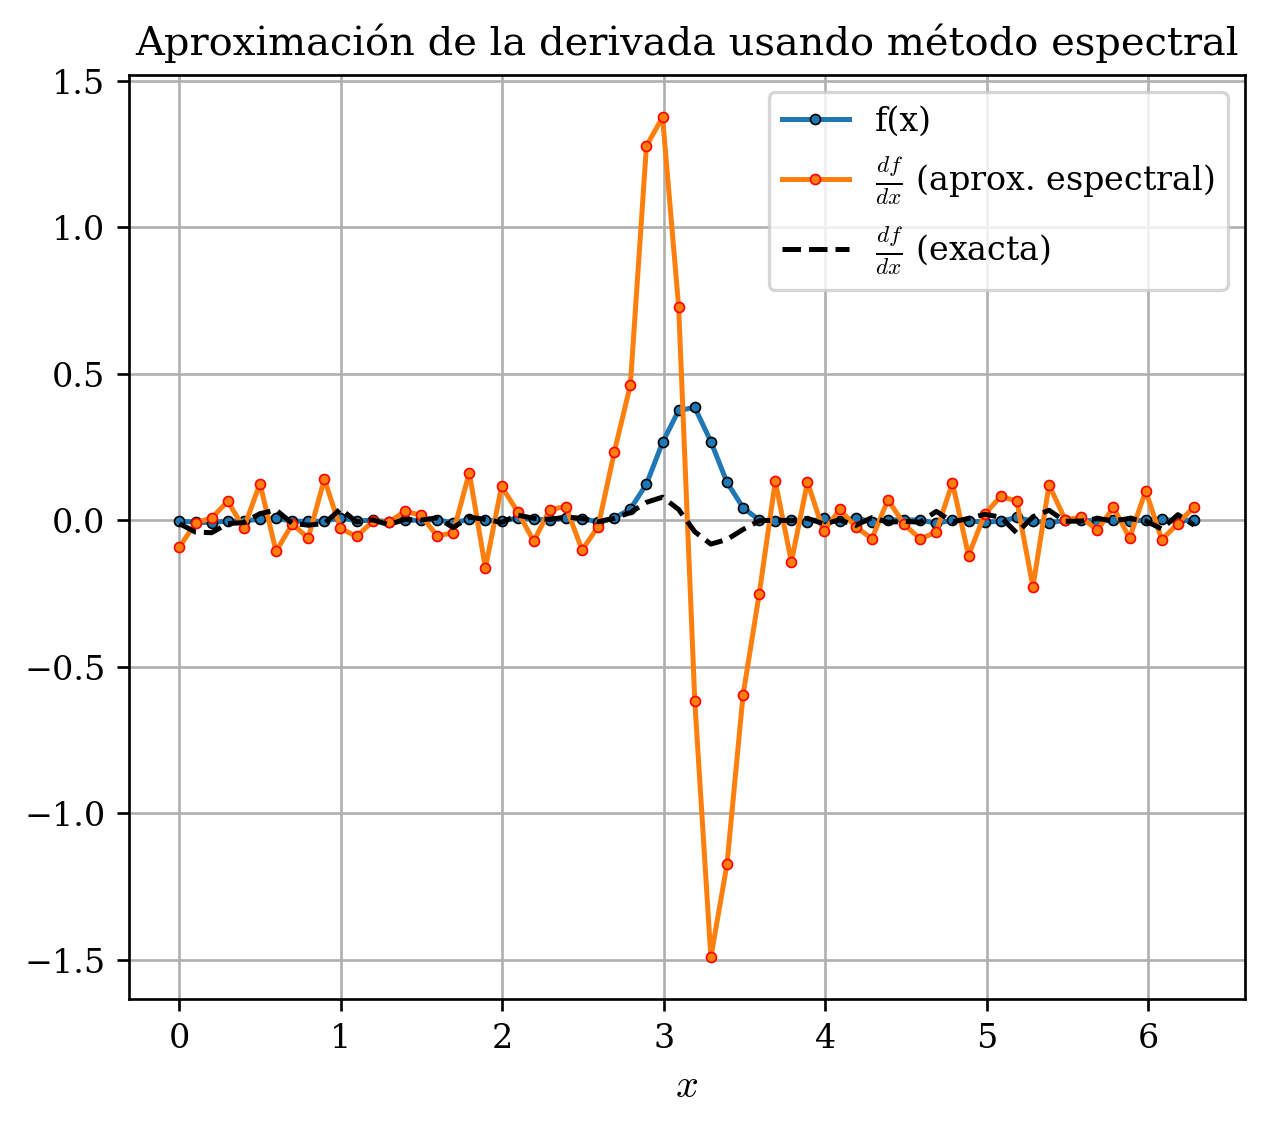

In [14]:
f_hat_ik = 1j * k * f_hat  # Multiplicamos por i k en el espacio de Fourier
# Deshacemos el shift
f_hat_ik = np.fft.ifftshift(f_hat_ik)
# Transformada inversa para obtener la derivada
df_dx = np.fft.ifft(f_hat_ik).real
# Alternativamente:
# df_dx = sp.fft.irfft(f_hat_ik).real
# Nota: .real porque la transformada inversa puede devolver un número complejo con parte imaginaria muy chica (errores numéricos)
# Veamos el resultado
plt.figure(figsize=(6, 5))
plt.plot(x, f, ".-", mec="k", mew=0.5, label="f(x)")
plt.plot(x, df_dx, ".-", mec="r", mew=0.5, label=r"$\frac{df}{dx}$ (aprox. espectral)")
# plt.plot(x, np.gradient(f, dx), ".-", mec="g", mew=0.5, label=r"$\frac{df}{dx}$ (aprox. diferencias finitas)")
plt.plot(x, - 2*(x - np.pi) * f, "k--", label=r"$\frac{df}{dx}$ (exacta)")
plt.grid()
plt.legend()
plt.title("Aproximación de la derivada usando método espectral")
plt.xlabel("$x$")
# plt.ylabel(r"$f(x), \frac{df}{dx}$")
plt.show()

*Sugerencia:* Prueben agregar ruido a la señal original y vean cómo afecta a la derivada aproximada usando el método espectral. Prueben también variar la cantidad de puntos, y la forma funcional de la señal original.

---
### Ejercicio 1

1.1. Considere la función $u(x) = \sin(x) \cos(3x)$ en el intervalo $[0, 2\pi]$. Discretice el dominio con $N=64$ puntos equiespaciados (incluyendo $x=0$ pero no $x=2\pi$, ya que es periódico).

1.2. Calcule analíticamente su primera derivada $u'(x)$ y su segunda derivada $u''(x)$.

1.3. Implemente una función `spectral_derivative(u, L, n=1)` que tome un vector de valores de la función `u` en puntos equiespaciados en $[0, L]$, la longitud del dominio `L`, y el orden de la derivada `n`, y devuelva el vector de la $n$-ésima derivada calculada usando FFT. Asegúrese de manejar correctamente los números de onda $k$. *Hint: Use `scipy.fft.fftfreq` y `scipy.fft.fft`/`ifft`.*

1.4. Use esta función para calcular $u'(x)$ y $u''(x)$ numéricamente para la función del punto 1.1.

1.5. Grafique las derivadas numéricas junto con las analíticas. Calcule el error máximo absoluto entre la solución numérica y la exacta para ambas derivadas.

1.6. Repita para diferentes valores de $N$ (e.g., 8, 16, 32, 128) y observe cómo cambia el error. Compare esta convergencia con la que esperaría para el método de diferencias finitas (e.g., $O(h^2)$). Hint: La idea es que grafiquen el error vs $N$ en escala log-log. Debería verse una convergencia mucho más rápida (exponencial/espectral).

In [15]:
#1.1
u = lambda x: (0.5)*(np.sin(4*x) - np.sin(2*x)) #sin(x + 3x) + sin(x - 3x) = 2 sin(x) cos(3x)

N = 64
xs = np.linspace(0, 2*np.pi, num = N)

In [16]:
#1.2
dudx_teo = lambda x: (2*np.cos(4*x) - np.cos(2*x))
dudx_2_teo = lambda x: (-8*np.sin(4*x) + 2*np.sin(2*x))

In [19]:
#1.3
def spectral_derivative(u, L, n = 1):
  xs = np.linspace(0, L, num = len(u))
  u_hat = np.fft.fft(u)
  k = 2 * np.pi * np.fft.fftfreq(len(u), d = xs[1] - xs[0])
  k = np.fft.fftshift(k)
  u_hat = np.fft.fftshift(u_hat)
  u_hat_ik = ((1j * k)**n)*u_hat
  u_hat_ik = np.fft.ifftshift(u_hat_ik)
  dudx_n = np.fft.ifft(u_hat_ik).real
  return dudx_n

In [20]:
#1.4
dudx_spec = spectral_derivative(u(xs), 2*np.pi, n=1)
dudx_2_spec = spectral_derivative(u(xs), 2*np.pi, n=2)

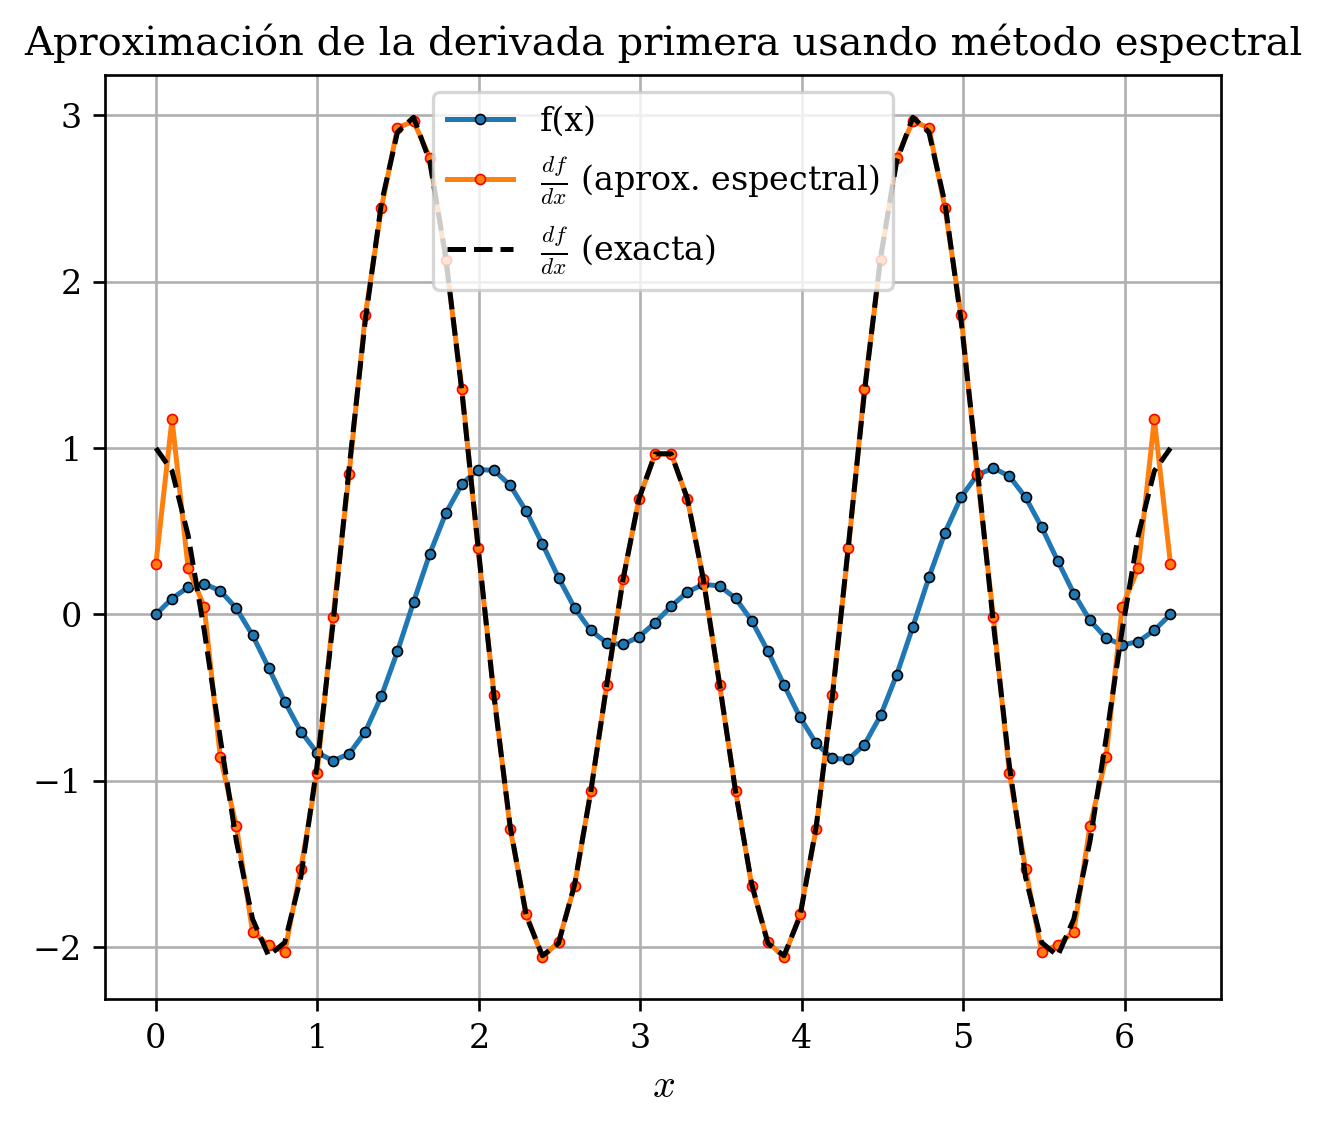

Error máx abs de dudx: 0.6956088069734525


In [26]:
#1.5
plt.figure(figsize=(6, 5))
plt.plot(xs, u(xs), ".-", mec="k", mew=0.5, label="f(x)")
plt.plot(xs, dudx_spec, ".-", mec="r", mew=0.5, label=r"$\frac{df}{dx}$ (aprox. espectral)")
plt.plot(xs, dudx_teo(xs), "k--", label=r"$\frac{df}{dx}$ (exacta)")
plt.grid()
plt.legend()
plt.title("Aproximación de la derivada primera usando método espectral")
plt.xlabel("$x$")
plt.show()8, 16, 32, 128


error_max_dudx = np.max(np.abs(dudx_teo(xs) - dudx_spec))
print('Error máx abs de dudx:', error_max_dudx)

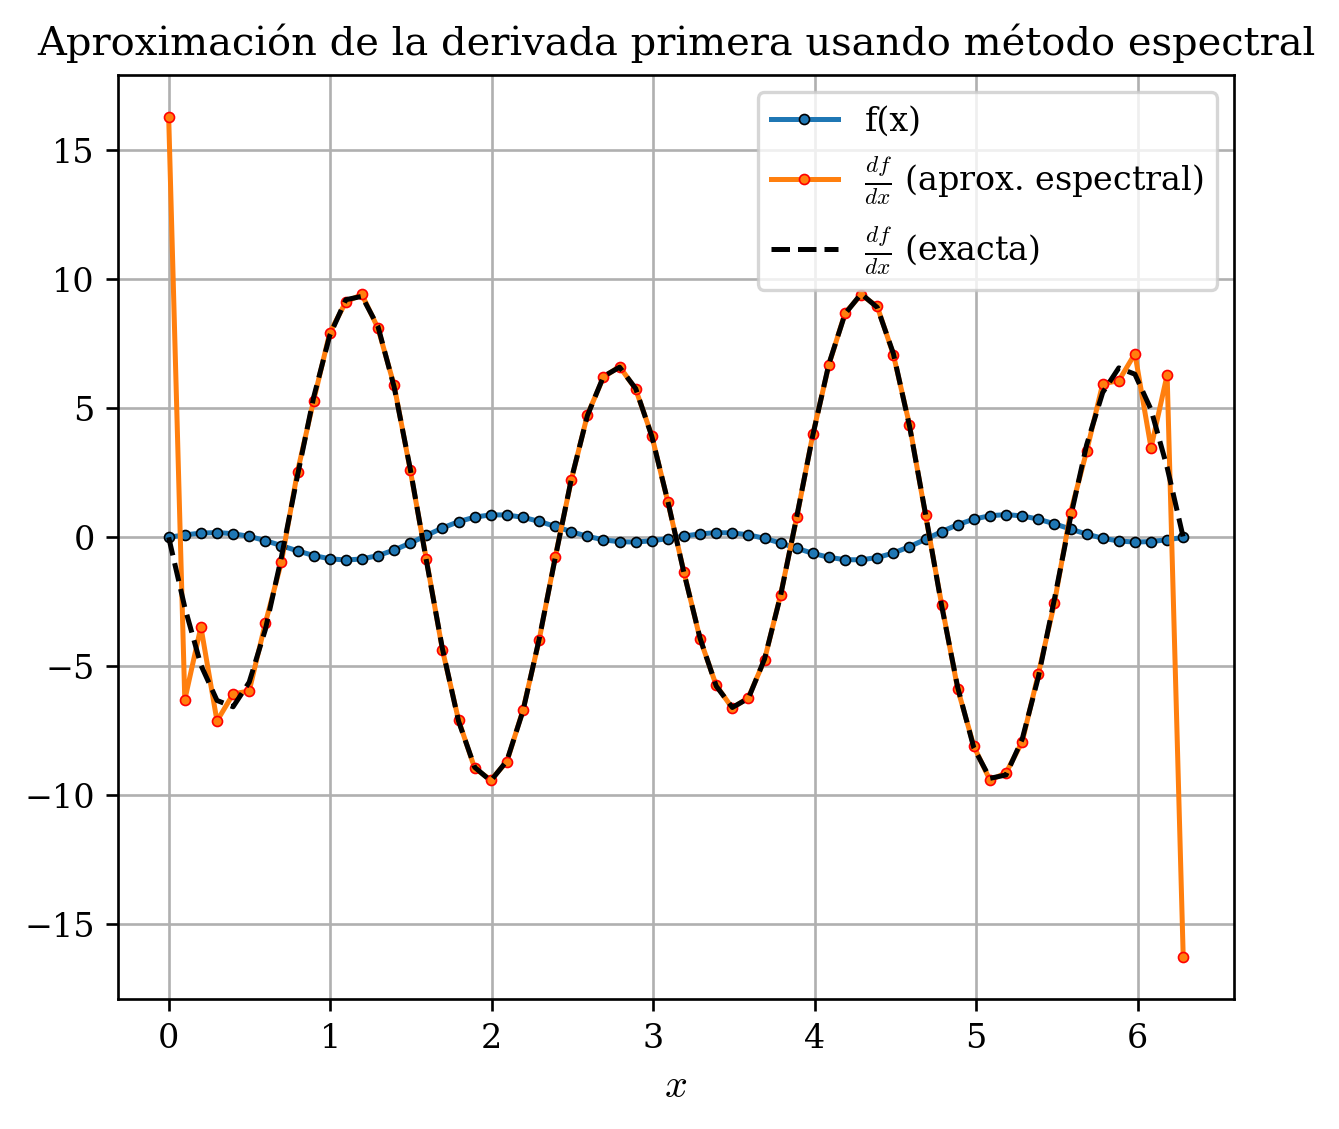

Error máx abs de dudx: 16.274200537769538


In [27]:
plt.figure(figsize=(6, 5))
plt.plot(xs, u(xs), ".-", mec="k", mew=0.5, label="f(x)")
plt.plot(xs, dudx_2_spec, ".-", mec="r", mew=0.5, label=r"$\frac{df}{dx}$ (aprox. espectral)")
plt.plot(xs, dudx_2_teo(xs), "k--", label=r"$\frac{df}{dx}$ (exacta)")
plt.grid()
plt.legend()
plt.title("Aproximación de la derivada primera usando método espectral")
plt.xlabel("$x$")
plt.show()

error_max_dudx_2 = np.max(np.abs(dudx_2_teo(xs) - dudx_2_spec))
print('Error máx abs de dudx:', error_max_dudx_2)

In [42]:
#1.6
err_diff = lambda N, L: (L/N)**2

error_dudx_N = []
error_dudx_2_N = []
error_diff_N = []

Ns = [8, 16, 32, 128, 256, 512]

for N in Ns:
  xs = np.linspace(0, 2*np.pi, num = N)
  dudx_spec = spectral_derivative(u(xs), 2*np.pi, n=1)
  dudx_2_spec = spectral_derivative(u(xs), 2*np.pi, n=2)
  error_dudx_N.append(np.max(np.abs(dudx_teo(xs) - dudx_spec)))
  error_dudx_2_N.append(np.max(np.abs(dudx_2_teo(xs) - dudx_2_spec)))
  error_diff_N.append(err_diff(N, 2*np.pi))

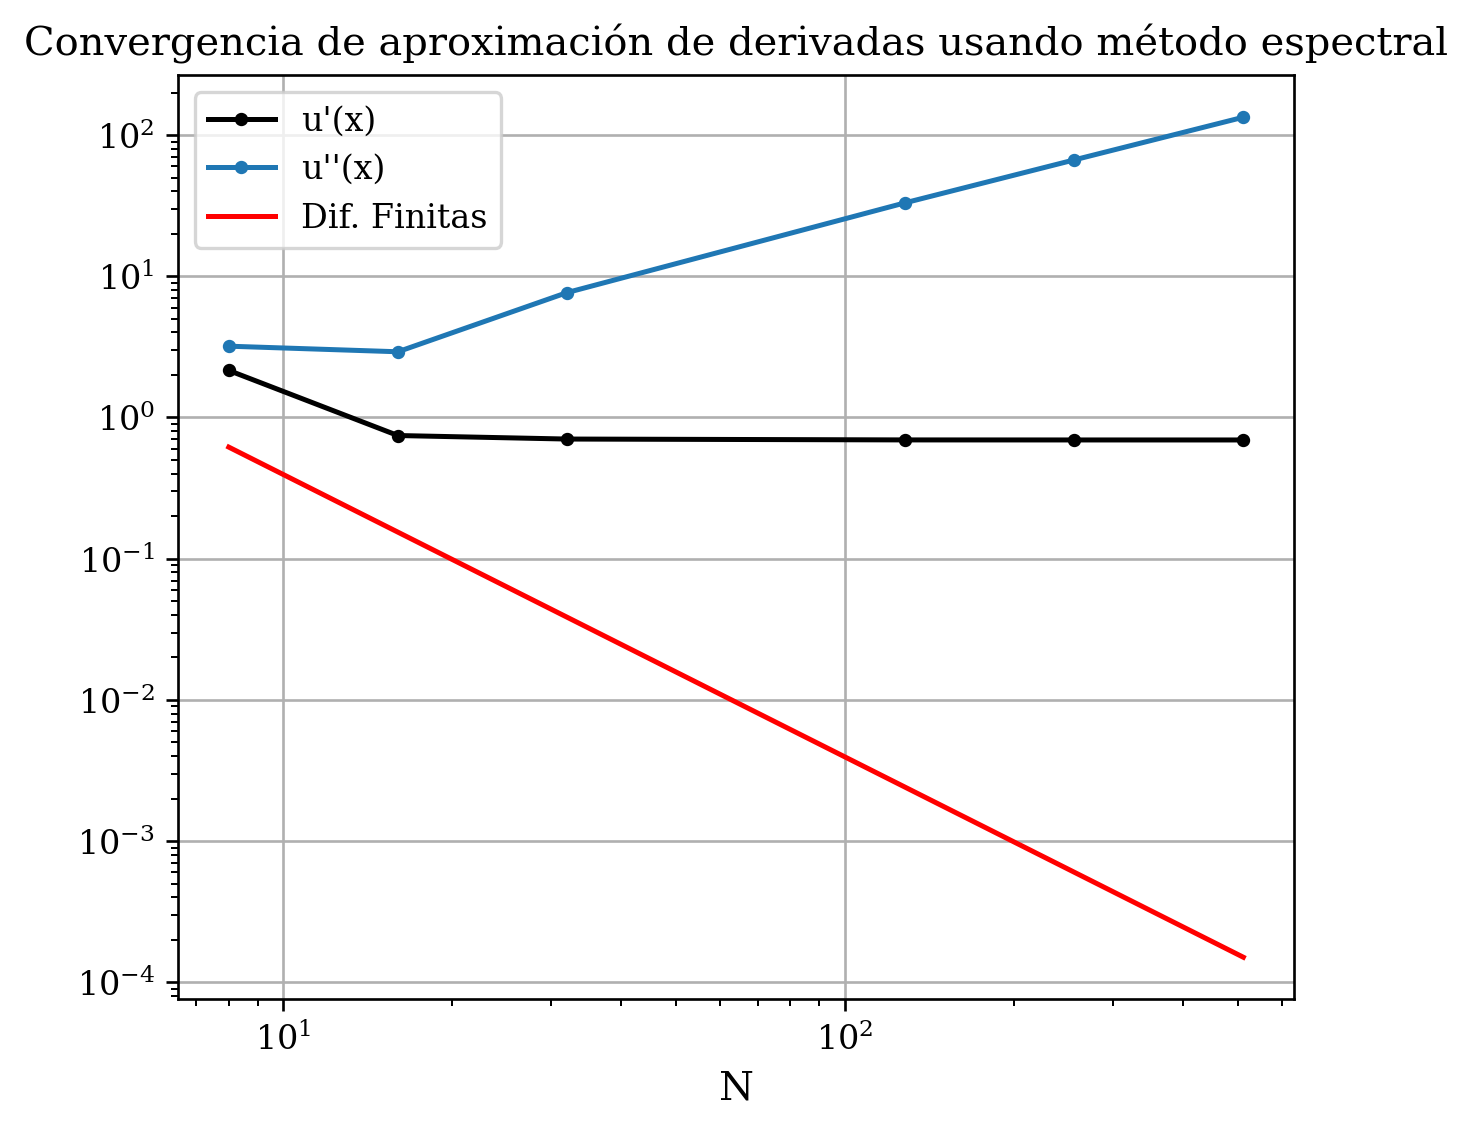

In [45]:
plt.figure(figsize=(6, 5))
plt.plot(Ns, error_dudx_N, "k.-", label="u'(x)")
plt.plot(Ns, error_dudx_2_N, ".-", label="u''(x)")
plt.plot(Ns, error_diff_N, "r-", label = "Dif. Finitas")
plt.grid()
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title("Convergencia de aproximación de derivadas usando método espectral")
plt.xlabel("N")
plt.show()

---
## Matrices de diferenciación espectral

Al igual que en diferencias finitas, podemos representar la operación de derivación espectral mediante una **matriz de diferenciación** $D$ tal que $\mathbf{u}' = D \mathbf{u}$, donde $\mathbf{u}$ es el vector de valores $u_j$ y $\mathbf{u}'$ es el vector de las derivadas $u'_j$.

Sin embargo, a diferencia de las matrices de FD que son *ralas* (sparse), las matrices de diferenciación espectral son generalmente *densas* (dense). Esto refleja la naturaleza global del método: el valor de la derivada en un punto $x_j$ depende de los valores de la función en *todos* los puntos del dominio.

La construcción explícita de estas matrices es posible, pero computacionalmente, suele ser más eficiente calcular las derivadas usando el método basado en FFT descrito anteriormente, especialmente para problemas grandes (la FFT tiene un costo $O(N \log N)$, mientras que la multiplicación por matriz densa es $O(N^2)$).


**Ejemplo:**

Para $N$ puntos equiespaciados $x_j = 2\pi j / N$ en $[0, 2\pi]$, los elementos de la matriz de diferenciación espectral de Fourier de primer orden $D$ (que aproxima $u'(x)$) están dados por:

$$
D_{jk} =
\begin{cases}
\frac{1}{2} (-1)^{j+k} \cot\left(\frac{x_j - x_k}{2}\right) & \text{si } j \neq k \\
0 & \text{si } j = k
\end{cases}
$$

Construyamos esta matriz para un $N$ pequeño y veamos cómo funciona.


In [46]:
# 1. Definimos un N pequeño y el dominio L
N_ejemplo = 8
L_ejemplo = 2 * np.pi
dx = L_ejemplo / N_ejemplo
x_ej = np.linspace(0, L_ejemplo, N_ejemplo, endpoint=False) # x_j = 2*pi*j/N

# 2. Inicializamos la matriz D
D_spectral = np.zeros((N_ejemplo, N_ejemplo))

# 3. Llenamos la matriz D usando la fórmula
for j in range(N_ejemplo):
    for k in range(N_ejemplo):
        if j != k:
            D_spectral[j, k] = 0.5 * (-1)**(j - k) / np.tan((x_ej[j] - x_ej[k]) / 2.0)
            # La diagonal (j=k) permanece en 0

# 4. Imprimimos la matriz (redondeada para claridad)
print(np.round(D_spectral, 3))

# 5. (Opcional) Verifiquemos con u(x) = sin(x)
u_ej = np.sin(x_ej)
u_prime_exact = np.cos(x_ej)

# Derivada usando la Matriz D
u_prime_matrix = D_spectral @ u_ej

print("u'(x) (Exacta): ", np.round(u_prime_exact, 3))
print("u'(x) (Usando D):", np.round(u_prime_matrix, 3))
error_matrix = np.max(np.abs(u_prime_matrix - u_prime_exact))
print(f"Error (D): {error_matrix:.2e}")


[[ 0.     1.207 -0.5    0.207 -0.    -0.207  0.5   -1.207]
 [-1.207  0.     1.207 -0.5    0.207 -0.    -0.207  0.5  ]
 [ 0.5   -1.207  0.     1.207 -0.5    0.207 -0.    -0.207]
 [-0.207  0.5   -1.207  0.     1.207 -0.5    0.207 -0.   ]
 [ 0.    -0.207  0.5   -1.207  0.     1.207 -0.5    0.207]
 [ 0.207  0.    -0.207  0.5   -1.207  0.     1.207 -0.5  ]
 [-0.5    0.207  0.    -0.207  0.5   -1.207  0.     1.207]
 [ 1.207 -0.5    0.207  0.    -0.207  0.5   -1.207  0.   ]]
u'(x) (Exacta):  [ 1.     0.707  0.    -0.707 -1.    -0.707 -0.     0.707]
u'(x) (Usando D): [ 1.     0.707  0.    -0.707 -1.    -0.707 -0.     0.707]
Error (D): 4.44e-16


Como podemos observar en la salida, la matriz es antisimétrica ($D_{jk} = -D_{kj}$) y **densa** (casi todos sus elementos son no nulos). Esto contrasta fuertemente con la matriz de diferencias finitas, que era *rala* (sólo tenía elementos en unas pocas diagonales). Esta densidad es la razón matemática por la que el método es *global*. La derivada en el punto $j$ depende de los valores de la función en todos los puntos $k$ y no sólo en puntos localmente vecinos de la grilla.

Respecto a la eficiencia computacional, el cálculo con $\mathbf{u}' = D \mathbf{u}$ implica una multiplicación de una matriz densa ($N \times N$) por un vector ($N \times 1$). Esta operación requiere $N \times N = N^2$ multiplicaciones. El costo computacional es $O(N^2)$. Por otro lado, el método que usa la FFT que vimos previamente en este Colab, tiene un costo dominado por las transformadas de Fourier, el cual es $O(N \log N)$. Entonces, calcular la derivada usando la matriz $D$ densa es computacionalmente mucho menos eficiente que usar la FFT. Por ejemplo, si hablamos de N=1000, estamos hablando de 1000000 de operaciones contra 10000, aproximadamente.

Por este motivo, la matriz de Fourier (periódica) casi nunca se construye explícitamente. Sin embargo, las matrices de diferenciación para métodos espectrales no periódicos (como Chebyshev o Legendre) sí se construyen y usan comúnmente en la práctica. Estas matrices también son densas, pero su construcción y uso son la forma estándar de implementar esos métodos para problemas con condiciones de contorno de Dirichlet o Neumann.

---
# Resolución de ecuaciones diferenciales con métodos espectrales

Ahora que sabemos cómo calcular derivadas espectralmente, podemos usarlo para resolver Ecuaciones Diferenciales Ordinarias (ODEs) o Ecuaciones en Derivadas Parciales (PDEs).

Una estrategia común es la **colocación espectral**, que consiste en aproximar la solución $u(x)$ (o $u(x,t)$) mediante una expansión espectral truncada (e.g. una serie de Fourier), y luego imponer que la ecuación diferencial se satisfaga en un conjunto de puntos de colocación (generalmente los mismos puntos de la grilla $x_j$). Esto transforma la ecuación diferencial en un sistema de ecuaciones algebraicas, ya sea para los coeficientes espectrales $\hat{u}_k$ o para los valores nodales $u_j$.


---
## BVP periódico

Para el problema de condiciones de contorno (BVP) periódicas, consideremos resolver $u''(x) = f(x)$ en $[0, 2\pi]$ con periodicidad en los bordes.

Usando el método espectral de Fourier:

1.  Representamos $u(x) \approx \sum \hat{u}_k e^{ikx}$ y $f(x) \approx \sum \hat{f}_k e^{ikx}$.
2.  La ecuación se transforma en el espacio de Fourier a:
    $$
    (ik)^2 \hat{u}_k = \hat{f}_k \quad \Rightarrow \quad -k^2 \hat{u}_k = \hat{f}_k
    $$
3.  Podemos despejar los coeficientes $\hat{u}_k$:
    
    $$
    \hat{u}_k = -\frac{\hat{f}_k}{k^2} \quad \text{para } k \neq 0
    $$
    
4.  El caso $k=0$ (modo constante) requiere cuidado. La ecuación original $-0^2 \hat{u}_0 = \hat{f}_0$ implica que $\hat{f}_0$ debe ser cero para que exista solución (la integral de $f(x)$ debe ser cero). Si $\hat{f}_0 = 0$, el coeficiente $\hat{u}_0$ (el valor medio de $u(x)$) queda indeterminado por la ecuación diferencial y debe fijarse por una condición adicional o normalización si es necesario. Si el problema original tiene una solución única, $\hat{u}_0$ estará determinado.

El procedimiento numérico sería:
1. Calcular $\hat{f}_k = \text{FFT}(f(x_j))$.
2. Calcular $\hat{u}_k = -\hat{f}_k / k^2$ para $k \neq 0$. Manejar $\hat{u}_0$ (a menudo se pone a cero si no hay otra condición, o se determina de otra forma).
3. Calcular $u_j = \text{IFFT}(\hat{u}_k)$.


---
### Ejercicio 2

Resuelva la siguiente ecuación diferencial ordinaria (ODE) de segundo orden con condiciones de contorno periódicas en $[0, 2\pi]$ usando el método espectral de Fourier:

$$
u''(x) + 2u(x) = \cos(3x) - \sin(x)
$$
con $u(0) = u(2\pi)$ y $u'(0) = u'(2\pi)$.

Para esto, siga las siguientes consignas:

2.1.  Defina la función $f(x) = \cos(3x) - \sin(x)$ en la grilla discreta $x_j$ (usa $N=64$ por ejemplo).

2.2.  Calcule los coeficientes $\hat{f}_k$ usando la FFT.

2.3. Teniendo en cuenta que la ecuación transformada al espacio de Fourier, para los coeficientes $\hat{u}_k$, será:
$$
(ik)^2 \hat{u}_k + 2 \hat{u}_k = \hat{f}_k \quad \Rightarrow \quad (-k^2 + 2) \hat{u}_k = \hat{f}_k
$$

Resuelva para $\hat{u}_k = \hat{f}_k / (2 - k^2)$. ¿Hay algún valor de $k$ para el cual $2 - k^2 = 0$?

2.4. Calcule la anti-transformada $\hat{u}_k$ usando la IFFT para obtener la solución $u(x_j)$.

2.5.  Verifique la solución, sabiendo que la solución analítica es $u(x) = -\frac{1}{7}\cos(3x) - \sin(x)$. Grafique la solución numérica y la analítica, y calcule el error máximo absoluto.

In [ ]:
#2.1
f = lambda x: np.cos(3*x) - np.sin(x)

xj = np.


---
### Oscilador lineal forzado


Sea el oscilador armónico forzado (con masa $m=1$ para simplificar):

$$\ddot{x}(t) + \gamma \dot{x}(t) + \omega_0^2 x(t) = f(t)$$

Donde $\gamma$ es el amortiguamiento, $\omega_0$ es la frecuencia natural y $f(t)$ es la fuerza externa.

Recordemos que la transformada de Fourier de las derivadas es

* $\mathcal{F}\{\dot{x}(t)\} = (i\omega) \hat{x}(\omega)$
* $\mathcal{F}\{\ddot{x}(t)\} = (i\omega)^2 \hat{x}(\omega) = -\omega^2 \hat{x}(\omega)$
Donde $\hat{x}(\omega)$ es la transformada de $x(t)$.

Entonces, reemplazando, la ecuación diferencial se convierte en una ecuación algebraica para cada frecuencia $\omega$:

$$(-\omega^2) \hat{x}(\omega) + \gamma (i\omega) \hat{x}(\omega) + \omega_0^2 \hat{x}(\omega) = \hat{f}(\omega)$$

Agrupamos términos para despejar $\hat{x}(\omega)$:

$$\hat{x}(\omega) \left[ (\omega_0^2 - \omega^2) + i \gamma \omega \right] = \hat{f}(\omega)$$

Y la solución en el espacio de Fourier es:

$$\hat{x}(\omega) = \frac{\hat{f}(\omega)}{(\omega_0^2 - \omega^2) + i \gamma \omega}$$

De esta manera, una vez que tenemos $\hat{x}(\omega)$, podemos anti-transformar para obtener la solución de $x(t)$ en el dominio temporal original.

$$x(t) = \mathcal{F}^{-1}\{\hat{x}(\omega)\}$$

Este método encuentra la solución de estado estacionario (la parte de la solución que perdura después de que los transitorios iniciales se desvanecen) de forma increíblemente rápida y precisa.


---
#### Ejercicio 3

Sea la ecuación del oscilador armónico lineal forzado

$$\ddot{x} + \gamma \dot{x} + \omega_0^2 x = f(t)$$

Con frecuencia natural $\omega_0 = 5.0$ rad/s, y amortiguamiento $\gamma = 0.5$ $s^{-1}$.

3.1. Use el método espectral siguiendo los pasos expuestos previamente (aplicando FFT e IFFT), para encontrar la solución de estado estacionario $x(t)$ para un forzante $f(t)$ dado (pueden usar la función escalón o una función armónica como la del ejercicio 5 de la guía de Fourier si quieren comparar con una solución analítica).

3.2.  Observe la respuesta en amplitud y frecuencia para 3 casos de frecuencia del forzante: uno de los cuales debe ser usar la frecuencia natural, otro estar por debajo, y otro por encima. Considere la amplitud del forzante $f_0=1$.

3.3.  Explore el fenómeno de la **resonancia**. Valide la solución numérica comparándola con la curva de resonancia analítica. [Hint: para levantar la curva haga un barrido en frecuencias.]


In [ ]:
# # # COMPLETAR

---
## IVP con periodicidad espacial

Para el problema de valores iniciales (IVP) con periodicidad espacial, consideremos una ecuación diferencial sencilla, la ecuación de transporte unidimensional:
$$
\partial_t u = - c \partial_x u
$$
con una condición inicial $u(x,0) = u_0(x)$ y condiciones de contorno periódicas ($u(0,t) = u(L,t)$).

Acá lo que tenemos son dos variables (temporal y espacial). En este caso vamos a aplicar la transformada de Fourier en $x$ a ambos lados:
$$
\mathcal{F}[\partial_t u] = -c \mathcal{F}[\partial_x u]
$$
Usando las propiedades de la transformada de Fourier y luego discretizando en los $k$:
$$
\partial_t \hat{u}(k,t) = - c (i k) \hat{u}(k,t) \\
\Rightarrow \partial_t \hat{u}_k(t) = -cik\hat{u}_k(t)
$$
Esta es una ecuación diferencial ordinaria en el tiempo para cada $u_{k}$ que podemos resolver usando un método numérico para ODEs. Por ejemplo, reemplazando la derivada temporal por DF _forward_ (Euler explícito):
$$
\begin{align}
\partial_t \hat{u}_k(t) & = \frac{\hat{u}_k(t + \Delta t) - \hat{u}_k(t)}{\Delta t} \\
\implies \quad \hat{u}_k(t+\Delta t) & = \hat{u}_k(t) + \Delta t  (- c i k) \hat{u}_k(t) \\
\implies \quad \hat{u}_k^{n+1} & = \hat{u}_k^n + \Delta t  (- c i k) \hat{u}_k^n \quad \text{(discretizando en el tiempo)}
\end{align}
$$
(esto es solo una posible opción, en cambio podríamos haber usado un método de Runge-Kutta, o lo que quieran de la clase 3!)

Luego, una vez que tenemos la solución integrada en el tiempo en el espacio de frecuencias, alcanza con volver al espacio real aplicando la transformada inversa de Fourier:
$$
u(x,t+\Delta t) = \mathcal{F}^{-1}[\hat{u}(k,t+\Delta t)] \iff u_j^{n+1} = \text{IFFT}(\hat{u}_k^{n+1})
$$

Implementemoslo para que quede de ejemplo:

In [ ]:
# Definamos una condición inicial y veamos cómo evoluciona con el tiempo bajo la ecuación de transporte
c = 2.0
x = np.linspace(0, 2*np.pi, 64, endpoint=False)  # Noten que para hacer valer la condición de contorno períodica en 2π, sacamos el último valor porque es efectivamente el primero (pueden preguntar!)
u0 = np.exp(-(x - np.pi)**2 / 0.5) / np.sqrt(2*np.pi)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)
axs[0].plot(x, u0, ".-", mec="k", mew=0.5, label="$u(x,0)$")
axs[0].grid()
axs[0].legend()
axs[0].set_title("Condición inicial")
axs[0].set_xlabel("$x$")


# Ahora evolucionemos en el tiempo con el método espectral
u0_hat = np.fft.fft(u0)
k = 2 * np.pi * np.fft.fftfreq(len(u0), d=(x[1]-x[0]))
k = np.fft.fftshift(k)
u0_hat = np.fft.fftshift(u0_hat)

dt = 0.01
pasos_t = 120

u_hat = np.zeros(shape=(len(u0), pasos_t + 1), dtype=complex)  # Para guardar la evolución en el tiempo
u_hat[:, 0] = u0_hat  # Condición inicial en el espacio de Fourier
for n in range(pasos_t):
    u_hat[:, n + 1] = u_hat[:, n] + dt * (-1j * c * k) * u_hat[:, n]  # Euler explícito en el espacio de Fourier
# Deshacemos el shift
u_hat = np.fft.ifftshift(u_hat, axes=0)
# Transformada inversa para obtener la evolución en el espacio real
u = np.fft.ifft(u_hat, axis=0).real

for n in range(0, pasos_t + 1, 10):
    axs[1].plot(x, u[:, n], ".-", mec="C"+str(n), mew=0.5, label=f"$u(x,{n*dt:.1f})$")
axs[1].grid()
axs[1].set_title("Evolución en el tiempo")
axs[1].set_xlabel("$x$")

plt.show()

In [ ]:
# También podemos hacer un gráfico 2D para mostrar la evolución en el tiempo con los pasos intermedios

dt = 0.01
pasos_t = 120
u_hat = np.zeros(shape=(len(u0), pasos_t + 1), dtype=complex)  # Para guardar la evolución en el tiempo
u_hat[:, 0] = u0_hat  # Condición inicial en el espacio de Fourier
for n in range(pasos_t):
    u_hat[:, n + 1] = u_hat[:, n] + dt * (-1j * c * k) * u_hat[:, n]  # Euler explícito en el espacio de Fourier
# Deshacemos el shift
u_hat = np.fft.ifftshift(u_hat, axes=0)
# Transformada inversa para obtener la evolución en el espacio real
u = np.fft.ifft(u_hat, axis=0).real

plt.figure(figsize=(10, 6))
X, T = np.meshgrid(x, np.arange(0, pasos_t*dt + dt, dt))
plt.pcolormesh(X, T, u.T, shading="auto", cmap="viridis")
plt.colorbar(label="$u(x,t)$")
plt.title("Evolución de la señal bajo la ecuación de transporte")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.show()

In [ ]:
# A modo de comparación, resolvamos la misma ecuación usando diferencias finitas centrales
dx = x[1] - x[0]
dt = 0.01
pasos_t = 120
u_fd = np.zeros(shape=(len(u0), pasos_t + 1))  # Para guardar la evolución en el tiempo
u_fd[:, 0] = u0  # Condición inicial
# Defino la matriz de Diferencias Finitas con C.C. periódicas
D = (np.diag(np.ones(len(u0) - 1), k=1) - np.diag(np.ones(len(u0) - 1), k=-1)) / (2*dx)
D[-1, 0] = 1 / (2*dx)
D[0, -1] = - 1 / (2*dx)
for n in range(pasos_t):
    dudx = D @ u_fd[:, n]
    u_fd[:, n + 1] = u_fd[:, n] - c * dt * dudx  # Euler explícito en el espacio real



plt.figure(figsize=(10, 6))
for n in range(0, pasos_t + 1, 10):
    plt.plot(x, u_fd[:, n], ".-", mec="C"+str(n), mew=0.5, label=f"$u(x,{n*dt:.1f})$")
plt.grid()
plt.title("Evolución en el tiempo")
plt.xlabel("$x$")

plt.show()

plt.figure(figsize=(10, 6))
X, T = np.meshgrid(x, np.arange(0, pasos_t*dt + dt, dt))
plt.pcolormesh(X, T, u_fd.T, shading="auto", cmap="viridis")
plt.colorbar(label="$u(x,t)$")
plt.title("Evolución de la señal bajo la ecuación de transporte (Diferencias finitas)")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.show()

_Comentario_: El método de integración temporal elegido para este ejemplo no es estable para esta ODE. La solución analítica para una condición inicial $u_0(x)$ es $u(x,t) = u_0(x - ct)$. Prueben aumentando la cantidad de pasos y vean que esto no sucede para la solución numérica hallada.

---
### Ejercicio 4

Apliquen un método espectral para resolver la siguiente ecuación con condiciones de contorno periódicas:
$$
\partial_t u = -\alpha \partial_x u + \beta f(x)
$$
con condición inicial $u(x,0) = e^{- x^2} \cos(6 x)$ en el intervalo $[-\pi, \pi]$.

Para esto:

4.1 Analiticamente apliquen la transformada de Fourier en $x$ a ambos lados de la ecuación diferencial y obtengan la ecuación diferencial ordinaria resultante para cada modo $k$.

4.2 Grafiquen la condición inicial y el valor absoluto de los coeficientes de su serie de Fourier.

4.3 Implementen un método numérico para ODEs (pueden usar Euler explícito, o un método de Runge-Kutta) para integrar la ecuación diferencial ordinaria en el espacio de frecuencias a partir de la condición inicial. Pueden usar $\alpha = 3, \beta = 5, f(x) = e^{-|x|}$ e integrar por 150 pasos con $dt = 0.001$ pero también pueden probar otros parámetros. Finalmente apliquen la transformada inversa de Fourier para volver al espacio real y obtener la solución aproximada en el tiempo. Grafiquenla solución inicial y la solución final. Opcionalmente grafiquen la evolución con un gráfico 2D o una animación. Más opcionalmente aún: grafiquen la evolución de los coeficientes de la serie de Fourier en el tiempo.


_Sugerencia:_ Si implementan un método de Runge-Kutta, vean cuantos pasos más pueden dar sin que explote la solución.

In [ ]:
## COMPLETAR

---
# Metodos pseudo-espectrales

En los casos anteriores, vimos la transformada de un término lineal, es decir, $\mathcal{F}\{x\} = \hat{x}(\omega)$. En el caso no lineal (por ejemplo, $x^3$), la transformada de un término no lineal no es simple, ya que $\mathcal{F}\{x^3(t)\} \neq \hat{x}^3(\omega)$. De hecho, por el teorema de la convolución, $\mathcal{F}\{x^3\}$ implica una convolución múltiple de $\hat{x}(\omega)$ consigo mismo ($\hat{x} * \hat{x} * \hat{x}$), lo cual es computacionalmente muy dificil de tratar y no nos permite despejar $\hat{x}(\omega)$ fácilmente de manera algebraica. Calcular esta convolución para $N$ coeficientes tiene un costo computacional de $O(N^2)$. Esto es muy lento y anula la principal ventaja de la FFT, que tiene costo $O(N \log N)$. Además, la ecuación para cada $\hat{x}(\omega)$ quedaría acoplada a todos los demás modos de una forma muy compleja.

La solución a esto es el **método pseudo-espectral**, que fue diseñado justamente para manejar términos no lineales de forma eficiente, evitando realizar la convolución. El método consiste en trabajar en **dominios distintos las distintas partes del problema**. Las derivadas se calculan en el espacio de Fourier (donde son simples multiplicaciones) y los términos no lineales se calculan en el espacio real (donde son simples multiplicaciones). El método consiste entonces en ir y venir entre ambos espacios usando la FFT y su inversa en cada paso temporal, y avanzar en el tiempo iterando entre ambos.

Existen distintas **estrategias para avanzar en el tiempo** dentro de un esquema pseudo-espectral. En todos los casos se alterna entre el espacio real y el espectral, pero lo que cambia es la forma en que se combinan las partes lineales y no lineales de la ecuación. El avance temporal puede ser:
**explícito**, usando integradores explícitos estándar (e.g. Euler, RK); **implícito o semi-implícito**, tratando la parte lineal implícitamente y la no lineal explícitamente (“IMEX”), lo que puede ser necesario cuando hay rigidez (e.g. difusión fuerte); **iterativo**, implementando un esquema tipo punto fijo o similar, que puede ser útil si la ecuación es estacionaria o se busca convergencia a un estado fijo, aunque no es lo más general.
La elección depende de la ecuación y de la estabilidad numérica buscada.

Como ejemplo, se pueden resolver PDEs no lineales usando un método pseudo-espectral explícito, donde la ecuación se evalúa en cada paso de tiempo alternando FFT e IFFT, y la evolución temporal se realiza mediante un integrador explícito, de la siguiente manera:
1. Partimos de la condición inicial $u(x,0)$ en el espacio real.
2. Aplicamos la transformada de Fourier para obtener $\hat{u}(k,0)$.
4. Calculamos derivadas espaciales en el espacio de frecuencias.
3. Calculamos términos no lineales en el espacio real (aplicando la transformada inversa de Fourier si es necesario y volviendo al espacio de frecuencias luego).
6. Integramos en el tiempo usando un método numérico para ODEs en el espacio de frecuencias.
7. Repetimos desde el paso 4 hasta llegar al tiempo deseado.

Algo a considerar cuando multiplicamos funciones en el espacio físico y volvemos al espectral, es que se generan **modos espurios**. Esto se refiere a que pueden aparecer oscilaciones espurias debido a discontinuidades y al número limitado de funciones de base en una expansión espectral, que es un fenómeno al cual ya nos acercamos en las guías de Fourier, y se conoce como **fenómeno de Gibbs**. Los métodos pseudo-espectrales suelen tener esto en consideración y usar alguna estrategia para tratarlo. Algunas son **2/3 rule**, que consiste en truncar los modos altos después de cada paso; **padding/zero-padding**, ampliando temporalmente el espectro antes de multiplicar y recortar después; o usar un **filtrado espectral** suave, aplicando un decaimiento progresivo a los modos altos. Estas técnicas no cambian el método en esencia, pero afectan la estabilidad y precisión.

---
## Oscilador de relajación (no lineal) forzado

Sea el oscilador de relajación de Van der Pol forzado, dado por la ecuación

$$
\ddot{x} + \mu (x^{2}-1) \dot{x} + x = F \cos(\omega t)
$$

Donde $\mu$ es el parámetro de no linealidad (y amortiguamiento), $F$ es la amplitud del forzante y $\omega$ es la frecuencia del forzante.

A diferencia de los osciladores lineales (como el armónico simple), este sistema puede exhibir comportamientos complejos. Para sistemas lineales, proponemos una solución con la frecuencia del forzante y lo único que va a cambiar es la amplitud que va a depender de cuán lejos estemos de la frecuencia natural a la que le gusta oscilar al sistema. En los sistemas no lineales pueden aparecer otro tipo de comportamientos, como por ejemplo que durante un ciclo pueda seguir la frecuencia del forzante pero que en el siguiente ciclo ya no y por lo tanto tenga buena amplitud más chica. Entonces que el sistema tenga una periodicidad mayor, es decir, que aparezcan subarmónicos. Las soluciones subarmónicas son aquellas en las que el oscilador responde a una frecuencia que es una fracción ($1/n$) de la frecuencia del forzante.

---
### Ejercicio 5

Para encontrar el subarmónico 1/3 (frecuencia $\omega/3$) de un forzante $\omega$, buscamos una solución $x(t)$ que tenga el período $T = 3 (2\pi/\omega)$. Con $\omega=3$, el período que buscamos es $T=2\pi$.

En lugar de integrar en el tiempo (como IVP), vamos a encontrar la solución periódica estacionaria $x(t)$ directamente, resolviendo la ODE como un problema de condiciones de contorno (BVP) periódico en el dominio temporal $t \in [0, 2\pi]$ (el período del subarmónico 1/3 para $\omega=3$).

Usaremos el **método pseudo-espectral** para manejar el término no lineal. Para eso vamos a definir una función residuo

$$
R(x) = \ddot{x} + x + \mu (x^{2}-1) \dot{x} - F \cos(\omega t) = 0
$$

Discretizamos la ecuación en $N$ puntos $t_j$ y buscamos el vector $x = [x_0, ..., x_{N-1}]$ que hace que el "residuo" $R(x)$ sea cero en todos los puntos $t_j$; aproximamos las derivadas $\dot{x}$ y $\ddot{x}$ espectralmente mediante la FFT; calculamos el término no lineal $(x^2-1)\dot{x}$ en el espacio real (punto a punto); y resolvemos el sistema de ecuaciones algebraicas no lineales resultante. Esto lo podemos hacer delegando la parte iterativa (que era problemática) a un solver optimizado (tipo Newton), motivo por el cual usamos este enfoque definiendo una función residuo.

5.1.  Defina los parámetros ($\mu=2, F=5, \omega=3$), el dominio $t \in [0, 2\pi]$ y la grilla ($N=64$).

5.2.  Cree el vector del forzante $F \cos(\omega t_j)$.

5.3.  Cree los vectores de números de onda $k$ y los operadores de derivada en el espacio de Fourier ($ik$ y $-k^2$).

5.4.  Defina una función `calcular_residuo(x_j)` que tome un vector $\mathbf{x}$ y calcule el residuo $R(\mathbf{x})$ usando el método pseudo-espectral, a partir de considerar $\hat{x} = FFT(x)$, y por ende estimar las derivadas como $\dot{x} = IFFT(ik \cdot \hat{x})$, y $\ddot{x} = IFFT(-k^2 \cdot \hat{x})$, y el término no lineal en el espacio real.

5.5.  Use `scipy.optimize.fsolve` para encontrar el vector $x$ que hace cero a `calcular_residuo` (esto es mucho más simple que implementar la iteración de punto fijo a mano). Puede considerar usar una suposición inicial simple, como `x_guess = np.cos(t_j)` de argumento de entrada (ver documentación).

5.6.  Grafique la solución $x$ encontrada y su espectro de frecuencias (FFT) para verificar los picos en $k=1$ (subarmónico) y $k=3$ (forzante).

In [ ]:
# # # COMPLETAR

---
## Ecuación de Burgers: ondas de choque

Para aplicar el método pseudo-espectral en PDEs veamos la ecuación de Burgers unidimensional:
$$
\partial_t u + u\ \partial_x u = \nu \partial_{xx}u
$$
con condición inicial $u(x,0) = -\sin(2x)$ en el intervalo $[0, 2\pi]$ y condiciones de contorno periódicas.

Primero, aplicando la transformada de Fourier en $x$ a ambos lados, tenemos:
$$
\partial_t \hat{u}(k,t) + \mathcal{F}[u\ \partial_x u] = \nu (ik)^2 \hat{u}(k,t)
$$
reemplazando $u$ y $\partial_x u$ por su expresión en el espacio de frecuencias:
$$
\partial_t \hat{u}(k,t) + \mathcal{F}\left[\mathcal{F}^{-1}[\hat{u}(k,t)] \cdot \mathcal{F}^{-1}[ik \hat{u}(k,t)]\right] = -\nu k^2 \hat{u}(k,t)
$$
Finalmente, discretizando en $k$ y despejando tenemos:
$$
\partial_t \hat{u}_k = -\text{FFT}(\text{IFFT}(\hat{u}_k) \cdot \text{IFFT}(i k \hat{u}_k)) - \nu k^2 \hat{u}_k
$$

A partir de acá podemos usar cualquier método que nos guste para integrar el paso temporal de cada modo $\hat{u}_k$. A continuación proponemos una implementación con un método de Runge-Kutta de 4 orden para el paso temporal.

In [ ]:
from typing import Callable


def rk4(x_dot: Callable, x: np.ndarray, t: float, dt: float, *args, **kwargs):
    """Tal y como lo definimos en la clase 3!"""
    k1 = x_dot(x, t, *args, **kwargs)*dt
    k2 = x_dot(x + k1*0.5, t, *args, **kwargs)*dt
    k3 = x_dot(x + k2*0.5, t, *args, **kwargs)*dt
    k4 = x_dot(x + k3, t, *args, **kwargs)*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


def derivada_t_u_hat(u_hat: np.ndarray, t: float, nu: float, k: np.ndarray) -> np.ndarray:
    """Implementamos el lado derecho de la ecuación, que dado u_hat nos devuelve su derivada temporal!"""
    u_x_hat = 1j*k*u_hat
    u = np.fft.ifft(np.fft.ifftshift(u_hat))
    u_x = np.fft.ifft(np.fft.ifftshift(u_x_hat))
    v = u * u_x  # Calculamos u * u_x en el espacio real
    v_hat = np.fft.fftshift(np.fft.fft(v))
    v_hat[np.abs(k) >= 2/3 * np.max(np.abs(k))] = 0  # Dealising por Regla de 2/3 de Orszag
    u_t_hat = - v_hat - nu*(k**2)*u_hat
    # u_t_hat[np.abs(k) >= 2/3 * np.max(k)] = 0
    return u_t_hat


x = np.linspace(0, 2*np.pi, 256, endpoint=False)
dx = x[1] - x[0]
k = 2 * np.pi * np.fft.fftfreq(len(x), d=dx)
k = np.fft.fftshift(k)

u0 = -np.sin(2*x)  # Cambia esta linea para ver cómo evolucionan otras C.I.
# u0 = np.exp(-(x - np.pi)**2)
# u0 = np.cos(x) + np.cos(8*x) + np.sin(4*x)
u0_hat = np.fft.fft(u0)
u0_hat = np.fft.fftshift(u0_hat)

nu = 0.01
dt = 0.001
pasos_t = 2000
u_hat = np.zeros(shape=(len(u0), pasos_t + 1), dtype=complex)  # Para guardar la evolución en el tiempo
u_hat[:, 0] = u0_hat  # Condición inicial en el espacio de Fourier
for n in range(pasos_t):
    u_hat[:, n + 1] = rk4(derivada_t_u_hat, u_hat[:, n], t=n*dt, dt=dt, nu=nu, k=k)

# Deshacemos el shift
u_hat = np.fft.ifftshift(u_hat, axes=0)
# Transformada inversa para obtener la evolución en el espacio real
u = np.fft.ifft(u_hat, axis=0).real


fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
axs = axs.flatten()

X, T = np.meshgrid(x, np.arange(0, pasos_t*dt + dt, dt))
axs[0].pcolormesh(X, T, u.T, shading="auto", cmap="viridis")
axs[0].set_title("Evolución en el tiempo")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$t$")

K, T = np.meshgrid(k, np.arange(0, pasos_t*dt + dt, dt))
axs[1].pcolormesh(K, T, np.abs(np.fft.fftshift(u_hat, axes=0).T), shading="auto", cmap="viridis")
axs[1].set_title("Evolución en el espacio de frecuencias")
axs[1].set_xlabel("$k$")
axs[1].set_ylabel("$t$")

axs[2].plot(x, u[:, 0], ".-", mec="k", mew=0.5, label=r"$u(x,0)$")
axs[2].plot(x, u[:, -1], ".-", mec="r", mew=0.5, label=r"$u(x,t_f)$")
axs[2].grid()
axs[2].legend()
axs[2].set_title("Condición inicial y solución final")
axs[2].set_xlabel("$x$")

axs[3].plot(k, np.abs(np.fft.fftshift(u_hat[:, 0])), "o--", mec="k", mew=0.5, label=r"$|\ \hat{u}(k,0)\ |$")
axs[3].plot(k, np.abs(np.fft.fftshift(u_hat[:, -1])), "o--", mec="r", mew=0.5, label=r"$|\ \hat{u}(k,t_f)\ |$")
axs[3].grid()
axs[3].legend()
axs[3].set_title("Transformada de Fourier inicial y final")
axs[3].set_xlabel("$k$")

plt.show()

Arriba podemos ver la evolución de $u_0(x) = -\sin(2x)$, que en el ecuación de Burgers se transforma en una señal serrucho. Pueden probar modificando el código y ver que la evolución cualquier señal inicial presenta propiedades similares: "las pendientes negativas se exageran y tienden a infinito". Esto es, las soluciones a la ecuación de Burgers presentan discontinuidades (ondas de choque).

---
### Extra: Aliasing y regla de 2/3

Exploremos con un breve ejemplo cómo pueden aparecer modos espurios al multiplicar funciones en el método pseudoespectral para un caso cómo el de arriba dónde aparece el término no-lineal $u\cdot u'$.


Supongamos que tenemos la función:
$$
\begin{align}
u(x) = & \alpha \cos(k_1 x) + \beta \sin(k_2 x) \\
/\quad u'(x) = & -\alpha k_1 \sin(k_1 x) + \beta k_2 \cos(k_2 x) \\
\implies \quad v(x) \equiv u(x) \cdot u'(x) = & -\frac{\alpha^2 k_1}{2} \sin(2 k_1 x) + \frac{\beta^2 k_2}{2} \sin(2 k_2 x) \\
& + \frac{\alpha \beta}{2} (k_2 - k_1) \cos\left[(k_2 - k_1)x\right] + \frac{\alpha \beta}{2} (k_2 + k_1) \cos\left[(k_2 + k_1)x\right]
\end{align}
$$

Así, es claro que la transformada de $v(x)$ tendrá componentes en las frecuencias $2k_1$, $2k_2$, $(k_2 - k_1)$ y $(k_2 + k_1)$. Ahora, si $k_1$ y $k_2$ son suficientemente grandes, algunas de estas frecuencias pueden exceder el máximo número de onda representable en nuestra grilla discreta (el número de Nyquist, $k_{Ny} = \frac{N}{2} \frac{2\pi}{L}$, donde $N$ es el número de puntos y $L$ la longitud del dominio). Cuando esto sucede, las frecuencias más altas "se pliegan" de vuelta al rango representable, apareciendo como modos espurios en el espectro de $v(x)$. Este fenómeno se conoce como **aliasing**.

El siguiente código muestra cómo estas frecuencias se pliegan para un caso particular, y cómo al truncar con la reglar de 2/3 podemos sacarnos de encima esos modos altos (ojo: con esto también estamos truncando modos altos que podían no ser espurios, pero es un _trade off_ necesario).

In [ ]:
N = 32               # puntos en el dominio
N_dens = N**2       # puntos en el dominio de alta densidad para graficar la solución exacta
L = 2*np.pi           # longitud del dominio
x_vals = np.linspace(-L/2, L/2, N, endpoint=False)
x_dens = np.linspace(-L/2, L/2, N_dens, endpoint=False)
dx_vals = x_vals[1]-x_vals[0]
dx_dens = x_dens[1]-x_dens[0]

k_vals = np.fft.fftfreq(N, d=dx_vals) * 2 * np.pi
k_vals = np.fft.fftshift(k_vals)
k_max = np.max(np.abs(k_vals))  # Max(k) = N/2 2π/L


k_dens = np.fft.fftfreq(N_dens, d=dx_dens) * 2 * np.pi
k_dens = np.fft.fftshift(k_dens)

k1 = 9
alpha = 0.1
k2 = 10
beta = 0.05

def u_func(x: np.ndarray) -> np.ndarray:
    return alpha*np.cos(k1*x) + beta*np.sin(k2*x)


def u_x_func(x: np.ndarray) -> np.ndarray:
    return -alpha*k1*np.sin(k1*x) + beta*k2*np.cos(k2*x)


def v_func(x: np.ndarray) -> np.ndarray:
    return (
        -0.5*(alpha**2)*k1*np.sin(2*k1*x)
        - 0.5*alpha*beta*(k1 - k2)*np.cos((k1 - k2)*x)
        + 0.5*alpha*beta*(k1 + k2)*np.cos((k1 + k2)*x)
        + 0.5*(beta**2)*k2*np.sin(2*k2*x)
    )


def v_hat_func(k: np.ndarray) -> np.ndarray:
    v_hat = np.zeros_like(k, dtype=complex)

    # Terminos de sin(2 k1 x):  -0.5(A^2 k1) * sin(2 k1 x)
    v_hat[np.isclose(k,  2*k1)] += -(alpha**2) * k1 / (4j)
    v_hat[np.isclose(k, -2*k1)] +=  (alpha**2) * k1 / (4j)

    # Terminos de sin(2 k2 x):  +0.5(B^2 k2) * sin(2 k2 x)
    v_hat[np.isclose(k,  2*k2)] += -(beta**2) * k2 * (1j) / 4
    v_hat[np.isclose(k, -2*k2)] +=  +(beta**2) * k2 * (1j) / 4



    # Terminos de cos((k1 - k2) x): +0.5(AB)(k2 - k1) * cos((k1 - k2)x)
    v_hat[np.isclose(k,  (k1 - k2))] += (alpha * beta) * (k2 - k1) / 4.0
    v_hat[np.isclose(k, -(k1 - k2))] += (alpha * beta) * (k2 - k1) / 4.0

    # Terminos de cos((k1 + k2) x): +0.5(AB)(k1 + k2) * cos((k1 + k2)x)
    v_hat[np.isclose(k,  (k1 + k2))] += (alpha * beta) * (k1 + k2) / 4.0
    v_hat[np.isclose(k, -(k1 + k2))] += (alpha * beta) * (k1 + k2) / 4.0

    return v_hat



u_vals = u_func(x_vals)
u_vals_hat = np.fft.fft(u_vals)
u_vals_hat = np.fft.fftshift(u_vals_hat)
u_x_vals_hat = 1j * k_vals * u_vals_hat
u_x_vals = np.fft.ifft(np.fft.ifftshift(u_x_vals_hat)).real

v_vals = u_vals * u_x_vals
v_vals_hat = np.fft.fft(v_vals)
v_vals_hat = np.fft.fftshift(v_vals_hat)

v_vals_hat_trunc = v_vals_hat.copy()
k_trunc = 2/3 * k_max
v_vals_hat_trunc[np.abs(k_vals) >= k_trunc] = 0
v_vals_trunc = np.fft.ifft(np.fft.ifftshift(v_vals_hat_trunc)).real


u_dens = u_func(x_dens)
u_x_dens = u_x_func(x_dens)

v_dens = v_func(x_dens)
v_dens_hat = v_hat_func(k_dens)  # Acorde al parámetro norm de FFT


fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axs[0, 0].plot(x_dens, u_dens, '-k', lw=1, label=r"$u(x)$")
axs[0, 0].plot(x_dens, u_x_dens, '--k', lw=1, label=r"$u'(x)$")
axs[0, 0].plot(x_vals, u_vals, 'o', c="C0", mec="k", mew=0.5, label=r"$\vec{u}$")
axs[0, 0].plot(x_vals, u_x_vals, 'o', c="C1", mec="k", mew=0.5, label=r"$\vec{u}'$")
axs[0, 0].grid()
axs[0, 0].legend()
axs[0, 0].set_xlabel("$x$")
axs[0, 0].set_xlim(-L/2, L/2)

axs[0, 1].plot(x_dens, v_dens, '-k', lw=1, label=r"$v(x)$")
axs[0, 1].plot(x_vals, v_vals, 'o', mec="k", mew=0.5, label=r"$\vec{v}'$")
axs[0, 1].plot(x_vals, v_vals_trunc, 'o', c="C2", mec="k", mew=0.5, label=r"$\vec{v}_\text{trunc}$")
axs[0, 1].grid()
axs[0, 1].legend()
axs[0, 1].set_xlabel("$x$")
axs[0, 1].set_xlim(-L/2, L/2)

axs[1, 0].plot(k_vals, np.abs(u_vals_hat), 'o', mec="k", mew=0.5, label=r"$|\hat{u}_k|$")
axs[1, 0].plot(k_vals, np.abs(u_x_vals_hat), 'o', mec="k", mew=0.5, label=r"$|ik \hat{u}_k|$")
axs[1, 0].grid()
axs[1, 0].legend()
axs[1, 0].set_xlabel("$k$")
axs[1, 0].set_xlim(k_vals.min(), k_vals.max())


axs[1, 1].plot(k_vals, np.abs(v_vals_hat), 'o', mec="k", mew=0.5, label=r"$|\hat{v}_k|$")
axs[1, 1].plot(k_vals, np.abs(v_vals_hat_trunc), '^C2', mec="k", mew=0.5, label=r"$|\hat{v}_{k,\text{trunc}}|$")
axs[1, 1].plot(k_dens, np.abs(v_dens_hat) * len(k_vals), '.w', mec="k", mew=0.5, label=r"$|\hat{v}_{k,\text{teorico}}|$")
axs[1, 1].axvline(k_trunc, ls="--", c="k", lw=1, label=r"$k_\text{trunc}$")
axs[1, 1].axvline(-k_trunc, ls="--", c="k", lw=1)
# Descomentar para ver cómo se pliegan las frecuencias altas:
# axs[1, 1].axvline(2*k_max - 2*k1, ls="--", c="r", label="Plegado $2k_1$")
# axs[1, 1].axvline(2*k_max - 2*k2, ls="--", c="m", label="Plegado $2k_2$")
# axs[1, 1].axvline(2*k_max - (k1 + k2), ls="--", c="g", label="Plegado $(k_1 + k_2)$")
axs[1, 1].grid()
axs[1, 1].legend()
axs[1, 1].set_xlabel("$k$")
axs[1, 1].set_xlim(-2*max([k1, k2]) - 1, 2*max([k1, k2]) + 1)

plt.show()